# Importing Dependencies

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.integrate import odeint
from pprint import pprint

# Pre-processing of excel data files

In [2]:
conversionLib = {}
labels = ['368.15','353.15','338.15','323.15']
for elem in labels:
  conversionLib[elem] = pd.read_excel('conversionData.xlsx', sheet_name=elem,engine='openpyxl')

In [3]:
inletMFR_MAA = 108.8906 #kmol/h
molarRatio = 109.39/inletMFR_MAA
inletMFR_MeOH = inletMFR_MAA*molarRatio #kmol/h
inletVFR = 13.81   #m3/h
def generalDF(inletMFR_MAA,inletMFR_MeOH,inletVFR):

  initialConcentration = inletMFR_MAA/inletVFR # kmol/m3

  mfrMMA = {}
  mfrMeOH = {}
  mfrH2O = {}

  ##### Initial Conditions #####
  for elem in labels:
    mfrMMA[elem] = [0]                    # I.Cs may not be the same due to recycle
    mfrMeOH[elem] = [inletMFR_MeOH]       # I.Cs may not be the same due to recycle
    mfrH2O[elem] = [0]                    # I.Cs may not be the same due to recycle

  ##### MAA Calculations #####
  for elem in labels:
    conversionLib[elem]['concentrationMAA (kmol/m3)'] = initialConcentration*(1-conversionLib[elem]['Conversion (%)']*0.01)
    conversionLib[elem]['mfrMAA (kmol/h)'] = conversionLib[elem]['concentrationMAA (kmol/m3)']*inletVFR

  ##### Other Calculations #####
  for elem in labels:
    for j in range(1,len(conversionLib[elem])):
      diff = conversionLib[elem]['mfrMAA (kmol/h)'][j] - conversionLib[elem]['mfrMAA (kmol/h)'][j-1]

      newMfrMMA = mfrMMA[elem][j-1] - diff
      mfrMMA[elem].append(newMfrMMA)

      newMfrMeOH = mfrMeOH[elem][j-1] + diff
      mfrMeOH[elem].append(newMfrMeOH)

      newMfrH2O = mfrH2O[elem][j-1] - diff
      mfrH2O[elem].append(newMfrH2O)

    conversionLib[elem]['mfrMMA (kmol/h)'] = mfrMMA[elem]
    conversionLib[elem]['concentrationMMA (kmol/m3)'] = conversionLib[elem]['mfrMMA (kmol/h)']/inletVFR

    conversionLib[elem]['mfrMethanol (kmol/h)'] = mfrMeOH[elem]
    conversionLib[elem]['concentrationMethanol (kmol/m3)'] = conversionLib[elem]['mfrMethanol (kmol/h)']/inletVFR

    conversionLib[elem]['mfrWater (kmol/h)'] = mfrH2O[elem]
    conversionLib[elem]['concentrationWater (kmol/m3)'] = conversionLib[elem]['mfrWater (kmol/h)']/inletVFR
  return conversionLib
conversionLib = generalDF(inletMFR_MAA,inletMFR_MeOH,inletVFR)

pelletDensity = 0.75*1e6 #g/m3
bedPorosity = 0.4
bedBulkDensity = pelletDensity*(1-bedPorosity) #g/m3

def ratesDF(conversionLib):
  dfConversion = {}
  rates = {}
  ratesTh = {}

  ##### Initial Conditions #####
  for elem in labels:
    rates[elem] = []
    ratesTh[elem] = [0]

  for elem in labels: 
    dfConversion[elem] = pd.DataFrame()
    dfConversion[elem]['Time'] = conversionLib['368.15']['Time (min)']
    dfConversion[elem]['concentrationMAA (mol/m3)'] = conversionLib[elem]['concentrationMAA (kmol/m3)']*1e3
    dfConversion[elem]['concentrationMMA (mol/m3)'] = conversionLib[elem]['concentrationMMA (kmol/m3)']*1e3
    dfConversion[elem]['concentrationMethanol (mol/m3)'] = conversionLib[elem]['concentrationMethanol (kmol/m3)']*1e3
    dfConversion[elem]['concentrationWater (mol/m3)'] = conversionLib[elem]['concentrationWater (kmol/m3)']*1e3
    
    
    dfConversion[elem]['concentrationMAA (mol/kg_cat)'] = dfConversion[elem]['concentrationMAA (mol/m3)']*1000/bedBulkDensity
    dfConversion[elem]['concentrationMMA (mol/kg_cat)'] = dfConversion[elem]['concentrationMMA (mol/m3)']*1000/bedBulkDensity
    dfConversion[elem]['concentrationMethanol (mol/kg_cat)'] = dfConversion[elem]['concentrationMethanol (mol/m3)']*1000/bedBulkDensity
    dfConversion[elem]['concentrationWater (mol/kg_cat)'] = dfConversion[elem]['concentrationWater (mol/m3)']*1000/bedBulkDensity

  for elem in labels:
    for i in range(1,len(dfConversion[elem])):
      deltaT = dfConversion[elem]['Time'][i] - dfConversion[elem]['Time'][i-1]
      deltaC = dfConversion[elem]['concentrationMAA (mol/m3)'][i]-dfConversion[elem]['concentrationMAA (mol/m3)'][i-1]
      deltaR = deltaC/deltaT
      ratesTh[elem].append(deltaR)
    ratesTh[elem][0] = ratesTh[elem][1]
    dfConversion[elem]['rate (mol/m3.min)'] = ratesTh[elem]
    dfConversion[elem]['rate (mol/m3.s)'] = (dfConversion[elem]['rate (mol/m3.min)'])/60
    dfConversion[elem]['rate (mol/kg_cat.s)'] = (dfConversion[elem]['rate (mol/m3.s)']*1000)/bedBulkDensity
    #dfConversion[elem] = dfConversion[elem][1:15]
  return dfConversion

dfConversion = ratesDF(conversionLib)
conversionLib['368.15']

,Time (min),Conversion (%),concentrationMAA (kmol/m3),mfrMAA (kmol/h),mfrMMA (kmol/h),concentrationMMA (kmol/m3),mfrMethanol (kmol/h),concentrationMethanol (kmol/m3),mfrWater (kmol/h),concentrationWater (kmol/m3)
0,0.000000,0.000000,7.884909,108.890600,0.000000,0.000000,109.390000,7.921072,0.000000,0.000000
1,15.482621,13.347880,6.832441,94.356013,14.534587,1.052468,94.855413,6.868603,14.534587,1.052468
2,30.000000,23.784549,6.009519,82.991461,25.899139,1.875390,83.490861,6.045681,25.899139,1.875390
3,45.000000,33.366664,5.253978,72.557440,36.333160,2.630931,73.056840,5.290140,36.333160,2.630931
4,60.000000,41.946289,4.577483,63.215034,45.675566,3.307427,63.714434,4.613645,45.675566,3.307427
5,75.000000,50.040981,3.939223,54.400676,54.489924,3.945686,54.900076,3.975386,54.489924,3.945686
6,90.000000,57.997940,3.311824,45.736295,63.154305,4.573085,46.235695,3.347987,63.154305,4.573085
7,110.000000,64.399467,2.807070,38.765634,70.124966,5.077840,39.265034,2.843232,70.124966,5.077840
8,124.952948,67.713960,2.545725,35.156463,73.734137,5.339184,35.655863,2.581887,73.734137,5.339184
9,155.000000,72.935936,2.133977,29.470222,79.420378,5.750933,29.969622,2.170139,79.420378,5.750933


In [4]:
dfConversion['368.15']

,Time,concentrationMAA (mol/m3),concentrationMMA (mol/m3),concentrationMethanol (mol/m3),concentrationWater (mol/m3),concentrationMAA (mol/kg_cat),concentrationMMA (mol/kg_cat),concentrationMethanol (mol/kg_cat),concentrationWater (mol/kg_cat),rate (mol/m3.min),rate (mol/m3.s),rate (mol/kg_cat.s)
0,0.000000,7884.909486,0.000000,7921.071687,0.000000,17.522021,0.000000,17.602382,0.000000,-67.977396,-1.132957,-0.002518
1,15.482621,6832.441229,1052.468257,6868.603430,1052.468257,15.183203,2.338818,15.263563,2.338818,-67.977396,-1.132957,-0.002518
2,30.000000,6009.519296,1875.390190,6045.681497,1875.390190,13.354487,4.167534,13.434848,4.167534,-56.685297,-0.944755,-0.002099
3,45.000000,5253.978246,2630.931240,5290.140447,2630.931240,11.675507,5.846514,11.755868,5.846514,-50.369403,-0.839490,-0.001866
4,60.000000,4577.482565,3307.426921,4613.644766,3307.426921,10.172183,7.349838,10.252544,7.349838,-45.099712,-0.751662,-0.001670
5,75.000000,3939.223427,3945.686059,3975.385628,3945.686059,8.753830,8.768191,8.834190,8.768191,-42.550609,-0.709177,-0.001576
6,90.000000,3311.824389,4573.085097,3347.986590,4573.085097,7.359610,10.162411,7.439970,10.162411,-41.826603,-0.697110,-0.001549
7,110.000000,2807.069805,5077.839680,2843.232007,5077.839680,6.237933,11.284088,6.318293,11.284088,-25.237729,-0.420629,-0.000935
8,124.952948,2545.725056,5339.184429,2581.887258,5339.184429,5.657167,11.864854,5.737527,11.864854,-17.477808,-0.291297,-0.000647
9,155.000000,2133.976950,5750.932536,2170.139151,5750.932536,4.742171,12.779850,4.822531,12.779850,-13.703444,-0.228391,-0.000508


## Preliminary levenspiel plot from experimental results

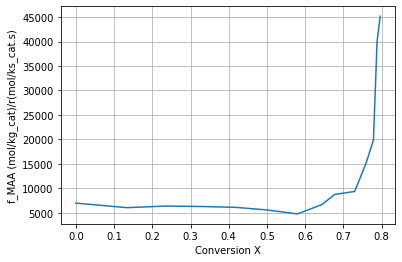

Weight of catalyst required to achieve 80% conversion = 5956.546924294677 kg
Total volume of reactor tubes required = 7.9420625657262365 m3


In [5]:
x = np.array(conversionLib['368.15']["Conversion (%)"])/100
flo = np.array(dfConversion['368.15']["concentrationMAA (mol/kg_cat)"])
rate = np.array(dfConversion['368.15']["rate (mol/kg_cat.s)"])*-1
y = flo/rate
plt.plot(x[:-1],y[:-1])
plt.xlabel('Conversion X')
plt.ylabel('f_MAA (mol/kg_cat)/r(mol/ks_cat.s)')
plt.grid()
plt.show()

weight = np.trapz(y[:-1],x[:-1])
print("Weight of catalyst required to achieve 80% conversion =", weight, "kg")
vol = weight/750
print("Total volume of reactor tubes required =", vol, "m3")

# Development of Langmuir-Hinshelwood curve-fitting of experimental data

In [39]:
from scipy.optimize import minimize
from scipy import stats


def kineticParam(elem,dfConversion):
  # Inputs:
  # - elem: Specificed temperature (K)
  # - dfConversion: pandas table of rates and concentrations
  # Output:
  # - x: list of kinetic parameters
  # - r: R2 value of L-H reversible kinetic model

  xm1 = dfConversion[elem]['concentrationMAA (mol/kg_cat)']
  xm2 = dfConversion[elem]['concentrationMethanol (mol/kg_cat)']
  xm3 = dfConversion[elem]['concentrationMMA (mol/kg_cat)']
  xm4 = dfConversion[elem]['concentrationWater (mol/kg_cat)']
  ym = dfConversion[elem]['rate (mol/kg_cat.s)']*-1

  # calculate y
  def calc_y(x):
      a = x[0]   # ks.ct^2.Kmaa.Kmeoh
      b = x[1]   # a/Kp, Kp = (Kmaa.Kmeoh.Ks)/(Kmma.Kh2o)
      c = x[2]   # Kmaa
      d = x[3]   # Kmeoh
      e = x[4]   # Kmma
      f = x[5]   # Kh2o
      num = a*xm1*xm2 - b*xm3*xm4
      denom = (1 + c*xm1 + d*xm2 + e*xm3 + f*xm4)**2
      y = num/denom #(mol/kg_cat.s)
      return y

  # define objective
  def objective(x):
      # calculate y
      y = calc_y(x)
      # calculate objective
      obj = 0.0
      for i in range(len(ym)):
          obj = obj + ((y[i]-ym[i])/ym[i])**2    
      # return result
      return obj

  # initial guesses
  x0 = np.zeros(6)
  x0[0] = 1 # a
  x0[1] = 1 # b
  x0[2] = 1 # c
  x0[3] = 1 # d
  x0[4] = 1 # e
  x0[5] = 1 # f

  # optimize
  # bounds on variables
  my_bnds = (-1,1)
  bnds = (my_bnds, my_bnds, my_bnds, my_bnds, my_bnds, my_bnds)
  solution = minimize(objective, x0, method='SLSQP', bounds=bnds)
  x = solution.x
  y = calc_y(x)

  slope, intercept, r_value, p_value, std_err = stats.linregress(ym,y)
  r2 = r_value**2
  from scipy.stats import t
  tinv = lambda p, df: abs(t.ppf(p/2, df))
  ts = tinv(0.05, len(x)-2)

  return x, r2

R^2 value of model is:  0.9840705471174183


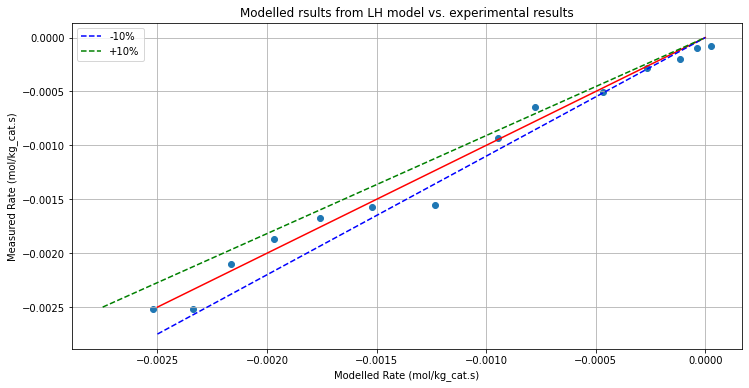

In [40]:
def calc_y(x):
  a = x[0]   # ks.ct^2.Kmaa.Kmeoh = k_cat ---------------- kg_cat/(mol.s)
  b = x[1]   # a/Kp, Kp = (Kmaa.Kmeoh.Ks)/(Kmma.Kh2o) ---------------- kg_cat/(mol.s)
  c = x[2]   # Kmaan --------- kg/mol
  d = x[3]   # Kmeoh --------- kg/mol
  e = x[4]   # Kmma --------- kg/mol
  f = x[5]   # Kh2o --------- kg/mol
  num = a*xm1*xm2 - b*xm3*xm4
  denom = (1 + c*xm1 + d*xm2 + e*xm3 + f*xm4)**2
  y = num/denom  # rate: (mol/kg_cat.s)
  return y

testTemp = labels[0]
testParam = kineticParam(testTemp,dfConversion)[0]
testRate = []
for i in range(len(dfConversion[testTemp])):
    xm1 = dfConversion[testTemp]['concentrationMAA (mol/kg_cat)'][i]
    xm2 = dfConversion[testTemp]['concentrationMethanol (mol/kg_cat)'][i]
    xm3 = dfConversion[testTemp]['concentrationMMA (mol/kg_cat)'][i]
    xm4 = dfConversion[testTemp]['concentrationWater (mol/kg_cat)'][i]
    r = calc_y(testParam)
    testRate.append(-r)
trainingRate = dfConversion[testTemp]['rate (mol/kg_cat.s)']

plt.figure(figsize=(12,6))

xsl = [-0.0025,-0.0020,-0.0015,-0.0010,-0.0005,0]
ysl = [-0.0025,-0.0020,-0.0015,-0.0010,-0.0005,0]
plt.plot(xsl,ysl,'r')

xsl2= [-0.0025,-0.0020,-0.0015,-0.0010,-0.0005,0]
ysl2= [-0.0025,-0.0020,-0.0015,-0.0010,-0.0005,0]
ysl2= [ysl2[i]*1.1 for i in range(len(ysl2))]
#xsl2= [xsl2[i]*1.1 for i in range(len(xsl2))]
plt.plot(xsl2,ysl2,'b--',label='-10%')
plt.plot(ysl2,xsl2,'g--',label='+10%')


plt.scatter(testRate[0:-1],trainingRate[0:-1])
plt.xlabel('Modelled Rate (mol/kg_cat.s)')
plt.ylabel('Measured Rate (mol/kg_cat.s)')
plt.title('Modelled rsults from LH model vs. experimental results')
print('R^2 value of model is: ',kineticParam(testTemp,dfConversion)[1] )
plt.legend()
plt.grid()
plt.show()

## Curve fitting of LH model results at 368.15 K

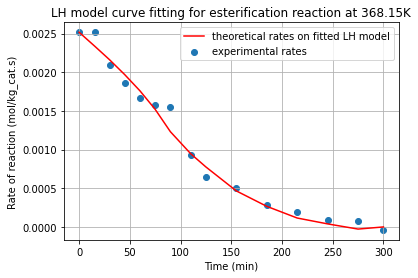

In [41]:
plt.plot(conversionLib[labels[0]]['Time (min)'],[-testRate[i] for i in range(len(testRate))],'r',label='theoretical rates on fitted LH model')
plt.scatter(conversionLib[labels[0]]['Time (min)'],[-trainingRate[i] for i in range(len(trainingRate))],label='experimental rates')
plt.xlabel('Time (min)')
plt.ylabel('Rate of reaction (mol/kg_cat.s)')
plt.title('LH model curve fitting for esterification reaction at 368.15K')
plt.grid()
plt.legend()
plt.show()

## Consolidation of rate constants and equilibrium constants at the 3 recorded temperatures

In [42]:
kineticParams = {}
r2values = {}
for temp in labels:
    kineticParams[temp] =  kineticParam(temp,dfConversion)[0]
    r2values[temp] = kineticParam(temp,dfConversion)[1]
print(kineticParams)    

{'368.15': array([9.67988661e-03, 6.75609754e-04, 9.51933988e-01, 9.51714947e-01,
       2.08777204e-01, 2.08776839e-01]), '353.15': array([0.00821758, 0.00104334, 0.99926446, 0.99849475, 0.62675121,
       0.62671547]), '338.15': array([0.00382115, 0.0031388 , 0.99986443, 0.99991467, 0.32349295,
       0.32346822]), '323.15': array([1., 1., 1., 1., 1., 1.])}


## Arhennius equation fitting

This section is carried to obtain the arrhenius equation, and to find the activation energy and pre-exponential factor

The gradient is:  -3890.1337238452047
The y-intercept is:  6.026671283393993
The r2 value is:  0.8929739709005377


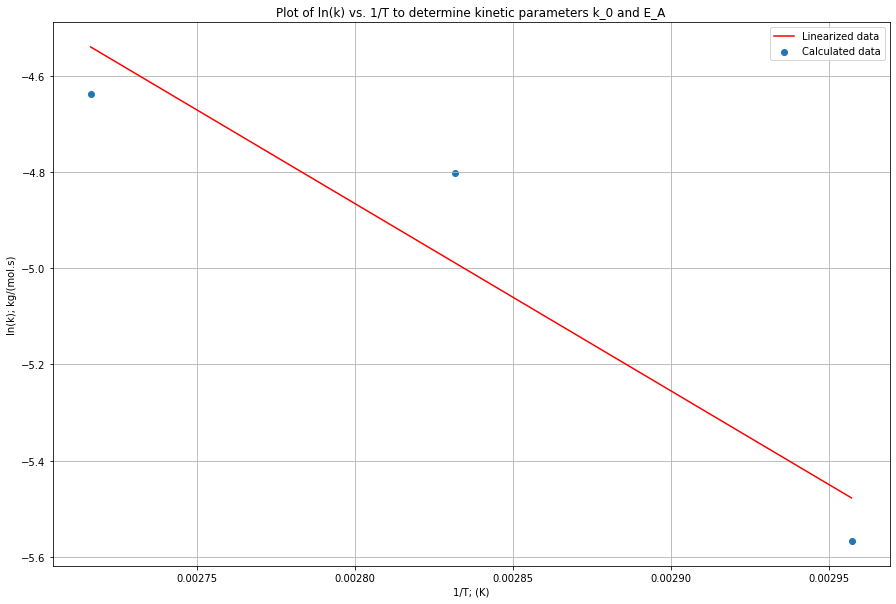

The activation enegy required is:  32.342571780049035  kJ/mol
The pre-exponential factor is:  414.3335324418411 kg/mol.s


In [43]:
yKcat = [kineticParams['368.15'][0],kineticParams['353.15'][0],kineticParams['338.15'][0]]
yKcatLog = np.array([math.log(yKcat[i]) for i in range(len(yKcat))])
xTemp = [368.15,353.15,338.15]
xTempInv = np.array([1/xTemp[i] for i in range(len(xTemp))])
xTempInv = xTempInv.reshape((-1,1))

modelArrhenius = LinearRegression()
resArrhenius = modelArrhenius.fit(xTempInv,yKcatLog)
print('The gradient is: ', resArrhenius.coef_[0])
print('The y-intercept is: ', resArrhenius.intercept_ )
predictedArrhenius = resArrhenius.predict(np.array(xTempInv))
print('The r2 value is: ',r2_score(yKcatLog,predictedArrhenius))

plt.figure(figsize=(15,10))
plt.scatter(xTempInv,yKcatLog,label='Calculated data')
plt.plot(xTempInv,predictedArrhenius,'r',label='Linearized data')
plt.xlabel('1/T; (K)')
plt.legend()
plt.ylabel('ln(k); kg/(mol.s)')
plt.title('Plot of ln(k) vs. 1/T to determine kinetic parameters k_0 and E_A')
plt.grid()
plt.show()

activationEnergy = -resArrhenius.coef_[0]*8.314 #J/mol
k0 = math.exp(resArrhenius.intercept_)

print('The activation enegy required is: ', activationEnergy*1e-3,' kJ/mol')
print('The pre-exponential factor is: ', k0, 'kg/mol.s')

Since rate constant is dependent on temperature, we first derived the pre-exponential factor and activation energy from 4 different experimental temperature, and fit into the arrhenius equation for us to calculate/predict the rate constant at different temperature

In [44]:
def rateConstant(temp):
    # Input: 
    #   -temperature: Kelvin
    # Output:
    #   -rateConstant: m3/(mol.s)
    k0 =  414.3335324418411 #kg/mol.s
    EA = 32.342571780049035*1e3 #J/mol
    rateConstant = k0*math.exp(-EA/(8.314*temp))
    return rateConstant

# Diffusion and reaction

### NKC-9 parameters

In [45]:
inletMFR_MAA = 91.2645 #kmol/h
molarRatio = 112.0164/inletMFR_MAA
inletMFR_MeOH = inletMFR_MAA*molarRatio #kmol/h
inletVFR = 13.31   #m3/h
pelletDensity = 1.25*1e6 #g/m3
pelletDiameter = 0.84*1e-3 #m
pelletRadius = pelletDiameter/2 #m
pelletSphericity = 1
bedPorosity = 0.4
bedBulkDensity = pelletDensity*(1-bedPorosity) #g/m3
pelletSpecificArea = 10.47 #m2/g, calculated by BET model

### Viscosity Correlation
The viscosities were extrapolated to the studied temperatures with the equation of Reid et al

In [46]:
maaViscosity = 1.34 # mPa.s or cP @ 25C INCLUDE REF
meohViscosity = 0.553 # mPa.s or cP @ 25C INCLUDE REF
refTemp = 273.15+25
def viscosityCorr(refTemp,temp,refVis):
    ## Correlation study done by Reid et al
    targetVis = refVis**(-0.2661) + (temp-refTemp)/233
    targetVis = targetVis**(-1/0.2661)
    return targetVis

### Scheibel Equation for Infinite Dilution
The accuracy of the
Scheibel-method was found to be ±20% in the study
of Li and Carr and they recommend its use over
the Wilke-Chang-method if measured diffusion coefficients are not available, as in our case.

As already mentioned, the infinite dilution diffusion
coefficients were corrected to liquid-phase activities
according to the Vignes equation as proposed by Rehfinger and Hoffmann for MTBE:


They were further converted to effective diffusion coefficients by assuming the tortuosity (τ) to be 4 as recommended by Satterfield
for ion-exchange resins and knowing the porosity (ε) of NKC-9 to be of 0.4 

In [47]:
def wilson(maaMolarVol, meohMolarVol,temp,inletMFR_MAA,inletMFR_MeOH):
    binary = 222.438
    fact = binary/(1.98721*temp)
    sigma = (meohMolarVol/maaMolarVol)*math.exp(-fact)
    maaMolFrac = inletMFR_MAA/(inletMFR_MAA+inletMFR_MeOH)
    lnActivity = -math.log(maaMolFrac*sigma)
    return lnActivity

maaMolarVol = (86.0904)/1.02 # cm3/mol  INCLUDE REF
meohDensity = (792*1e3)/1e6 # g/cm3     INCLUDE REF
meohMolarVol = 32.04/meohDensity #cm3/mol

def infiniteDF(temp,miu,va,vb):
    factor1 = (8.2*(10**-8)*temp)/(miu*(va**(1/3)))
    factor2 = 1 + ((3*vb)/va)**(2/3)
    dab0 = factor1*factor2
    return dab0
def effectiveDF(temp,inletMFR_MAA,inletMFR_MeOH):
    refTemp = 273.15+25
    miuA = viscosityCorr(refTemp,temp,maaViscosity)
    miuB = viscosityCorr(refTemp,temp,meohViscosity)
    maaMolFrac = inletMFR_MAA/(inletMFR_MAA+inletMFR_MeOH)
    infDCAB = infiniteDF(temp,miuA,maaMolarVol,meohMolarVol)
    infDCBA = infiniteDF(temp,miuB,meohMolarVol,maaMolarVol)
    lna = wilson(maaMolarVol, meohMolarVol,temp,inletMFR_MAA,inletMFR_MeOH)
    dab = ((infDCBA/infDCAB)**maaMolFrac)*infDCAB*(-lna/(math.log(maaMolFrac)))
    tort = 4
    porosity = 0.4
    effDC = dab*(porosity/tort) # cm2/s
    effDC = effDC*1e-4 # m2/s
    return effDC

print('Diffusivity coefficient is measured to be: ',effectiveDF(368.15,inletMFR_MAA,inletMFR_MeOH), 'm^2/s')

Diffusivity coefficient is measured to be:  1.5774197310004476e-09 m^2/s


### Mears Criterion
Mears proposed that when
$MR < 0.15$
external mass transfer effects can be neglected and no concentration gradient
exists between the bulk gas and external surface of the catalyst pellet.

In [48]:
kinematicVis = 0.4738 # cSt
kinematicVis = kinematicVis*1e-6 #m2/s
tubeDiam = 0.0254 # m
def massCoeff(temp,pelletDiameter,inletVFR,kinematicVis,tubeDiam,inletMFR_MAA,inletMFR_MeOH,bedPorosity):
    
    dab = effectiveDF(temp,inletMFR_MAA,inletMFR_MeOH)

    def gamma(pelletDiameter):
        # Shape factor
        a = math.pi*((pelletDiameter/2)**2)
        b = math.pi*(pelletDiameter**2)
        return a/b

    shapeFactor = gamma(pelletDiameter)
    
    def reynold(pelletDiameter,inletVFR,kinematicVis,tubeDiam,bedPorosity,shapeFactor):
        # inletVFR - m3/h
        area = math.pi*((tubeDiam/2)**2)
        velocity = (inletVFR/area)/3600 # m/s
        re = (pelletDiameter*velocity)/kinematicVis
        re = re/((1-bedPorosity)*shapeFactor)
        return re

    def schmidt(kinematicVis,dab):
        sc = kinematicVis/dab
        return sc

    def sherwood(re,sc):
        sh = (re**(1/2))*(sc**(1/3))
        return sh
    
    def coeffK(sh,dab,bedPorosity,pelletDiameter,shapeFactor):
        return ((dab*(1-bedPorosity))/(pelletDiameter*bedPorosity))*shapeFactor*sh #m/s
    
    re = reynold(pelletDiameter,inletVFR,kinematicVis,tubeDiam,bedPorosity,shapeFactor)
    sc = schmidt(kinematicVis,dab)
    sh = sherwood(re,sc)
    massCo = coeffK(sh,dab,bedPorosity,pelletDiameter,shapeFactor)
    massCo = round(massCo,5)
    return massCo

print('The mass transfer coefficient was calculated to be: ',massCoeff(368.15,pelletDiameter,inletVFR,kinematicVis,tubeDiam,inletMFR_MAA,inletMFR_MeOH,bedPorosity), 'm/s')

ror = -0.002518 # inlet, mol/kg.s
conc = 7884.909486 #mol/m3
def mears(ror,bedBulkDensity,order,pelletDiameter,temp,conc):
    mc = massCoeff(368.15,pelletDiameter,inletVFR,kinematicVis,tubeDiam,inletMFR_MAA,inletMFR_MeOH,bedPorosity)
    radius = pelletDiameter/2
    mr = (-ror*bedBulkDensity*order*radius)/(mc*conc)
    mr = round(mr,4)
    return mr

print('MR = ', mears(ror,bedBulkDensity,2,pelletDiameter,temp,conc), 'which is slightly less than 0.15')
    

The mass transfer coefficient was calculated to be:  0.00138 m/s
MR =  0.1458 which is slightly less than 0.15


### 2nd Order Overall Reaction Thiele Modulus
$\phi_1^2 = \frac{k_1R^2C_{MAA}}{D_e}$
where units are: 
1. $k_1: \frac{kg_{cat}}{mol.s}$

2. $R : m^2$
3. $C_{MAA}: \frac{mol}{kg_{cat}}$
4. $D_e: \frac{m^2}{s}$

In [49]:
def thieleFunc(temp,MFR_MAA,MFR_MeOH,inletVFR,bedBulkDensity):
    # Inputs:
    # -temp: K
    # -inletMFR_MAA: kmol/h
    # -vfr: m3/h
    k = rateConstant(temp) # kg_cat/mol.s
    R = pelletRadius  # m2
    mfr = (MFR_MAA*1e3)/3600 # mol/s
    vfr = inletVFR/3600
    concMaa = mfr/vfr # mol/m3
    concMaa = concMaa*1000/bedBulkDensity #mol/kg_cat
    De = effectiveDF(temp,MFR_MAA,MFR_MeOH) #m2/s
    thieleModulus = R/2*math.sqrt(k*concMaa/De)
    return thieleModulus

print('The thiele modulus was calculated to be: ', thieleFunc(368.15,inletMFR_MAA,inletMFR_MeOH,inletVFR,bedBulkDensity))  
    

The thiele modulus was calculated to be:  1.6516590107801685


### Weisz-Prater Criterion
The Weisz–Prater criterion uses measured values of the rate of reaction, to determine if internal diffusion is limiting the reaction. If $C_{wp} = \eta \phi_{1}^2 << 1$, there are no diffusion limitations and no concentration gradient exists within the pellet 

In [50]:
def wpCriterion(eta,phi):
    fac = eta*(phi**2)
    if fac < 1:
        print('NOT Internal diffusion limited')
    else:
        print('Since WP criterion > 1, reaction is internal diffusion limited!')
    return fac
        
print('The Weisz-Prater Criterion =', wpCriterion(0.6,thieleFunc(368.15,inletMFR_MAA,inletMFR_MeOH,inletVFR,bedBulkDensity)))


Since WP criterion > 1, reaction is internal diffusion limited!
The Weisz-Prater Criterion = 1.6367864927347948


### Initialization

In [51]:
porosity = 0.4
densityPellet = 1250 # kg/m3
pelletSA = 10470 # m2/kg
densityBed = (1-porosity)*densityPellet # kg/m3
diameterTube = 0.0254 #m
vfr = inletVFR/3600 # m3/s
densityFluid = 882.5 #kg/m3
thermalCond = 0.1476 # W/m.k
diameterPellet = 0.84*1e-3 #m
baseEnthalpy = 21292 #J/mol
vis = 0.0004181 # kg/m.s
wallThickness = 0.01 #m
thermalCondWall = 14 #W/m.k
hHeated = 1250 #W/m2.k
baseEnthalpy = 962*8.314 # J/mol
#baseEnthalpy = 80000 # J/mol

def heatCap(temp):
    maaMM = 86.09/1000 #kg/mol
    mmaMM = 100.121/1000 #kg/mol
    
    maa = -551.8+8.0712*temp #J/kg.k
    maa = maa*maaMM # J/mol.k
    
    meth = 13.41 + (-51.28*1e-3)*temp + (131.13*1e-6)*(temp**2)
    meth = meth*8.314 #J/mol.k
    meth = 83.56
    
    mma = 114.1 + 6.8299*temp
    mma = mma*mmaMM #J/mol.k
    
    #water = 8.712 + (1.23*1e-3)*temp + (-0.18*1e-6)*(temp**2)
    #water = water*8.314 #J/mol.k
    # Liquid Phase Heat Capacity (Shomate Equation)
    water = -203.6060 +  1523.290*(temp/1000) + -3196.413*((temp/1000)**2) + 2474.455*((temp/1000)**3) + 3.855326/((temp/1000)**2)
    #water = water/18 #J/mol.k
    
    return water+mma-meth-maa, maa,meth,mma,water

def enthalpy(baseEnthalpy,temp):
    cp = heatCap(temp)
    H = baseEnthalpy+cp[0]*(temp-(273.15+60))
    return H

fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
duty = enthalpy(baseEnthalpy,368.15)*fmaa0*0.7

# Calculation of overall heat transfer coefficient using Kern's Method

In [52]:
# Assume 1.25 triangular pitch

heatLoad = duty*0.7 # J/s
steamFlow = 900 # kg/h
mixtureFlow = (1.143e4)/3600 #kg/s
deltaTm = 40
initialU = 600 # W/m2.K
provisionalArea = heatLoad/(deltaTm*initialU) # m2
## choosing 25mm OD, 20mm ID 7.32m long tube 
length = 7.32 #m
do = 25 #mm
di = 20 #mm
areaSingleTube = math.pi*(do*1e-3)*length # m2
numberOfTubes = provisionalArea/areaSingleTube
bundleDiam = do*(numberOfTubes/0.249)**(1/2.207)
shellDiam = bundleDiam+68

################################ Tube side coefficient #####################################

meanTemp = 373.15 #K
tubeCA =  math.pi*((di/2)**2) # mm2
tubesPerPass = numberOfTubes/2
tubeFlowArea = tubesPerPass*tubeCA*1e-6 #m2
massVelo = mixtureFlow/tubeFlowArea #kg/sm2
densityMixture = 865.5 #kg/m3
mixtureVelo = 1.1 # m/s
Re = (densityMixture*mixtureVelo*di*1e-3)/(0.0003815)
cp = 2.322*1e3
Pr = (cp*0.0003815)/0.1483
lengthToDi = (length*1e3)/di  # = 366
    #using figure 19.23
jh = 3.1*1e-3
hTubeSide = (0.1483*jh*Re*(Pr**0.33))/(di*1e-3)

############################### Shell Side Coefficient ######################################

baffleSpacing = shellDiam/5 #mm
tubePitch = 1.25*do # mm
crossFlowArea = (((tubePitch-do)*shellDiam*baffleSpacing)/tubePitch)*1e-6 #m2
massVelo = (steamFlow/3600)*(1/crossFlowArea) # kg/m2.s
equivDiam = (1.1/do)*(tubePitch**2 - 0.917*(do**2)) # mm
meanShellTemp = (385+378)/2
ReShell = (massVelo*equivDiam*1e-3)/(1.304*1e-5)
PrShell = (1.908*1e3)*(1.304*1e-5)/(2.543*1e-2)
jhShell = 5*1e-3
NuShell = jhShell*ReShell**(PrShell**0.33)
hShellSide = ((2.543*1e-2)*NuShell)/(equivDiam*1e-3)
thirdTerm = (do*1e-3*math.log(do/di))/(2*14)
fourthTerm = (do/di)*(1/hTubeSide)
fifthTerm = (do/di)*(1/5000)

############################## Overall heat transfer Coefficient ##############################

overallU = 1/(1/hShellSide + 1/10000 + thirdTerm + fourthTerm + fifthTerm)
overallU = round(overallU,3)
print('The overall heat transfer coefficient is: ',overallU, 'W/m^2.K)')

The overall heat transfer coefficient is:  549.072 W/m^2.K)


In [53]:
def calc_yF(temp,xm1,xm2,xm3,xm4):
    x = kineticParam('368.15',dfConversion)[0]
    #a = x[0]   # ks.ct^2.Kmaa.Kmeoh = k_cat ---------------- kg_cat/(mol.s)
    a = rateConstant(temp)
    b = x[1]   # a/Kp, Kp = (Kmaa.Kmeoh.Ks)/(Kmma.Kh2o) ---------------- kg_cat/(mol.s)
    c = x[2]   # Kmaan --------- kg/mol
    d = x[3]   # Kmeoh --------- kg/mol
    e = x[4]   # Kmma --------- kg/mol
    f = x[5]   # Kh2o --------- kg/mol
    num = a*xm1*xm2 - b*xm3*xm4
    denom = (1 + c*xm1 + d*xm2 + e*xm3 + f*xm4)**2
    y = num/denom  # rate: (mol/kg_cat.s)
    return y

def shellDiam(do,numberOfTubes):
    sd = do*(numberOfTubes/0.249)**(1/2.207)
    sd = sd + 68*1e-3
    return sd

### Preliminary sizing

In [25]:
d = 0.0244
print("Inner shell diam is: ", d, "m")

area = math.pi*((d/2)**2)
n = 1572

totalDiam = shellDiam(d,n)
print("Outer diam is: ", totalDiam, "m")

aspectRatio = 7.98
l = totalDiam*aspectRatio
print("Length is: ",l, "m")

csa = math.pi*d*l*n
print('Total surface area for heat transfer is: ',csa,'m2') 

volSingle = area*l
volTotal = volSingle*n
print("Vol of total tubes used is: ", volTotal, "m3")

weight = volSingle*750*n
print("Weight of catalyst used is: ",weight, "kg")

Inner shell diam is:  0.0244 m
Outer diam is:  1.3541713778246594 m
Length is:  10.806287595040782 m
Total surface area for heat transfer is:  1302.1732280917374 m2
Vol of total tubes used is:  7.943256691359599 m3
Weight of catalyst used is:  5957.4425185197 kg


# Mathematical model couple ODEs

In [26]:
d = 0.0244
print("Inner shell diam is: ", d, "m")

area = math.pi*(d/2)**2
n = 1572

totalDiam = shellDiam(d,n)
print("Outer diam is: ", totalDiam, "m")

aspectRatio = 7.98
l = totalDiam*aspectRatio
print("Length is: ",l, "m")

csa = math.pi*d*l*n
print('Total surface area is: ',csa,'m2') 

volSingle = area*l
volTotal = l*math.pi*((totalDiam/2)**2)
volTubesTotal = volSingle*n
print("Total Reactor Vol is: ", volTotal, "m3")
print("Total Tube Vol is: ", volTubesTotal, "m3")

weight = volSingle*750*n
print("Weight is: ",weight, "kg")

numberOfTubes = n
diameterTube = d #m
temph0 = 125+273.15
maxLength = l
totalDiam = totalDiam
molarRatio = 1.1
fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
fmma0 = 0
fh2o0 = 0

def ODEfun(Y,L,fmaa0,inletVFR,temp,diameterTube,numberOfTubes,molarRatio):
    #########################
    fmeoh0 = fmaa0*molarRatio  #mol/s
    fmaa0 = fmaa0/numberOfTubes
    fmeoh0 = fmeoh0/numberOfTubes
    fmma0 = 0  #mol/s
    fh2o0 = 0  #mol/s
    ################################
    X = Y[0]     #-
    p = Y[1]     #Pa
    Tm = Y[2]    #K
    Th = Y[3]    #K
    ################################
    p0 = 500000 # pascal
    areaTube = math.pi*((diameterTube/2)**2) # m2
    a = 4/diameterTube # m2/m3 = m^-1
    vfr = (inletVFR/3600)/numberOfTubes
    velo = vfr/areaTube #m/s
    v = vfr*(p0/p) # m3/s
    heatMFR = 900 # kg/h
    heatMolarFlowRate = (heatMFR*1000)/(3600*18) # mol/s
    cpHeat = 28.02025 +  13.79716*(Tm/1000) + 3.742058*((Tm/1000)**2) + -2.416101*((Tm/1000)**3) + 0.123292/((Tm/1000)**2) # J/mol.k
    ##########################################
    fmaa = fmaa0*(1-X)
    cmaa = fmaa/v       # mol/m3
    cmaa = cmaa*1000/bedBulkDensity # mol/kg
    
    fmeoh = fmeoh0-(fmaa0*X)
    cmeoh = fmeoh/v #mol/m3
    cmeoh = cmeoh*1000/bedBulkDensity #mol/kg
    
    fmma = fmma0+(fmaa0*X)
    cmma = fmma/v #mol/m3
    cmma = cmma*1000/bedBulkDensity #mol/kg
    
    fh2o = fh2o0+(fmaa0*X)
    ch2o = fh2o/v #mol/m3
    ch2o = ch2o*1000/bedBulkDensity #mol/m3
    
    sumFlow = fmaa+fmeoh+fmma+fh2o
    initFlow = fmaa0+fmeoh0

    r = -calc_yF(Tm,cmaa,cmeoh,cmma,ch2o)

    dXdL = (-0.8*r/fmaa)*densityPellet*areaTube
    
    ###############################################
    
    alphaP = (-densityFluid*velo)/(densityFluid*diameterPellet)
    betaP = (1-porosity)/(porosity**3)
    charlieP = (150*(1-porosity)*vis)/diameterPellet
    deltaP = 1.75*densityFluid*velo
    pTerm = alphaP*betaP*(charlieP+deltaP)
    
    dPdL = pTerm*(p0/p)*(sumFlow/initFlow)
    ################################################
    
    U = 550
    alphaT = areaTube*(U*a*(Th-Tm) - 0.8*r*enthalpy(baseEnthalpy,temp)*(bedBulkDensity/1000))
    betaT = fmaa*heatCap(Tm)[1] + fmeoh*heatCap(Tm)[2] + fmma*heatCap(Tm)[3] + fh2o*heatCap(Tm)[4]
    dTmdL = alphaT/betaT
    
    #################################################
    
    alphaTh = U*areaTube*(Th-Tm)*numberOfTubes
    betaTh = heatMolarFlowRate*cpHeat*maxLength
    dThdL = alphaTh/betaTh
    
    ##################################################
    
    return np.array([dXdL,dPdL,dTmdL,dThdL])

L = np.linspace(0, l,50) # Range for the weight of the catalyst. 
temp0 = 368.15
y0 = np.array([0,592027.38,temp0,temph0]) # Initial values for the dependent variables X and y. 


Inner shell diam is:  0.0244 m
Outer diam is:  1.3541713778246594 m
Length is:  10.806287595040782 m
Total surface area is:  1302.1732280917374 m2
Total Reactor Vol is:  15.563729111574611 m3
Total Tube Vol is:  7.943256691359599 m3
Weight is:  5957.4425185197 kg


In [27]:
sol = odeint(ODEfun, y0, L, (fmaa0,inletVFR,temp0,diameterTube,numberOfTubes,molarRatio))


## Base Case Results

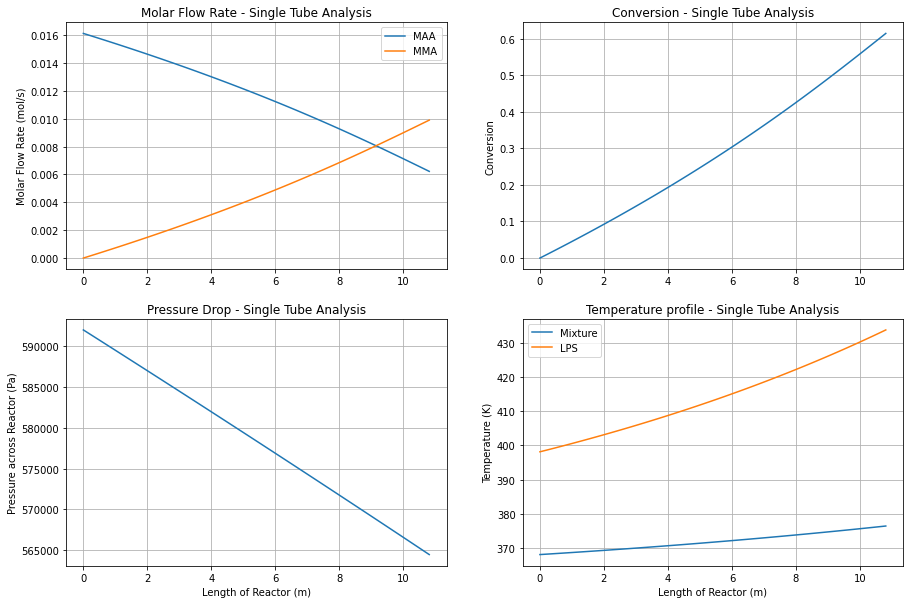

In [28]:
X = sol[:, 0] 
p = sol[:, 1] 
Tm = sol[:, 2] 
Th = sol[:, 3] 

fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
fmeoh0 = fmaa0*molarRatio
fmaa0 = fmaa0/numberOfTubes
fmeoh0 = fmeoh0/numberOfTubes

fmaa = [fmaa0*(1-X[i]) for i in range(len(X))]
fmethanol = [fmeoh0-(fmaa0*X[i]) for i in range(len(X))]
fmma = [fmma0+(fmaa0*X[i]) for i in range(len(X))]
#fh2o = [fh2o0+(fmaa0*X[i]) for i in range(len(X))]


fig, axs = plt.subplots(2, 2,figsize=(15,10))

axs[0,0].plot(L,fmaa,label='MAA')
axs[0,0].plot(L,fmma,label='MMA')


axs[0,0].set(ylabel='Molar Flow Rate (mol/s)',title='Molar Flow Rate - Single Tube Analysis')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(L,X)
axs[0,1].set(ylabel='Conversion',title='Conversion - Single Tube Analysis')
axs[0,1].grid()


axs[1,0].plot(L,p)
axs[1,0].set(xlabel='Length of Reactor (m)', ylabel='Pressure across Reactor (Pa)',title='Pressure Drop - Single Tube Analysis')
axs[1,0].grid()

axs[1,1].plot(L,Tm,label='Mixture')
axs[1,1].plot(L,Th,label='LPS')
axs[1,1].legend()
axs[1,1].set(xlabel='Length of Reactor (m)', ylabel='Temperature (K)',title='Temperature profile - Single Tube Analysis')
axs[1,1].grid()

plt.show()


# Costing Functions

## Manual import data from Turton's

In [29]:
params = ['k1','k2','k3','b1','b2','c1','c2','c3']
equipList = ['Reactor','Pump','HX','Vessel']

dfTurton = pd.DataFrame(columns=params)
k1 = [3.3496,3.3892,4.3247,3.4974]
k2 = [0.7235,0.0536,-0.3030,0.4485]
k3 = [0.0025,0.1538,0.1634,0.1074]
b1 = [2.25,1.89,1.63,2.25]
b2 = [1.82,1.35,1.66,1.82]
c1 = [0, -0.3935, 0.03881,0]
c2 = [0,0.3957,-0.11272,0]
c3 = [0,-0.00226,0.08183,0]
fm = [3.2,2.3,1.4,3.2]
dfTurton['k1'] = k1
dfTurton['k2'] = k2
dfTurton['k3'] = k3
dfTurton['b1'] = b1
dfTurton['b2'] = b2
dfTurton['c1'] = c1
dfTurton['c2'] = c2
dfTurton['c3'] = c3
dfTurton['fm'] = fm

dfTurton.index = equipList


dfTurton

,k1,k2,k3,b1,b2,c1,c2,c3,fm
Reactor,3.3496,0.7235,0.0025,2.25,1.82,0.00000,0.00000,0.00000,3.2
Pump,3.3892,0.0536,0.1538,1.89,1.35,-0.39350,0.39570,-0.00226,2.3
HX,4.3247,-0.3030,0.1634,1.63,1.66,0.03881,-0.11272,0.08183,1.4
Vessel,3.4974,0.4485,0.1074,2.25,1.82,0.00000,0.00000,0.00000,3.2


### Capital Costs

In [30]:
def capCost(k1,k2,k3,A):
    # Reactor: A - m^3
    # Pump: A - kW
    # HX: A - m^2
    # Process Vessel Vertical: A - m^3
    rhs = k1 + k2*math.log10(A) + k3*((math.log10(A))**2)
    cp = 10**(rhs)
    return cp

def pressureFactor(c1,c2,c3,p):
    # p: barg
    rhs = c1 + c2*math.log10(p) + c3*((math.log10(p))**2)
    fp = 10**rhs
    return fp

def pressureFactorVessel(p,diam):
    # p : barg
    # D: m
    fp = (((p+1)*diam)/(2*(850-0.6*(p+1))) + 0.00315)/0.0063
    return fp

def bmCost(k1,k2,k3,A,b1,b2,c1,c2,c3,fm,p,diam,vessel):
    cp = capCost(k1,k2,k3,A)
    if vessel == False:
        fp = pressureFactor(c1,c2,c3,p)
    else:
        fp = pressureFactorVessel(p,diam)
    term1 = b1+b2*fm*fp
    cbm = cp*term1
    return cbm

### Utility Costs

In [31]:
def utilityCost(ratio,temp,X):
    #### PRICINGS
    lambdaElec = 0.06 #$/kWh
    lambdaCW = 14.8/1000 #$/m3
    lambdaSteam = 27.70/1000 #$/kg

    ### pumps
    ePump = 0.2105*ratio + 2.27e-5 #kW, just for the methanol
    pump = lambdaElec*ePump #$/h
    
    ### reboiler
    eReboil = 1311.977*ratio - 5.0438*X + 2543.748 #kW
    reboil = lambdaElec*eReboil #$/h
    
    ### condenser
    eCond = 1388.851*ratio - 0.1399*X + 2108.974 #kW
    cond = lambdaElec*eCond #$
    
    ### pre-cooler
    mfrCW = -430.65*temp + 163769.9 #kg/h
    vfrCW = -0.43537*temp + 165.5646 #m3/h
    CW = lambdaCW*vfrCW #$/h
    
    ### reactor HX heating using steam
    baseEnthalpy = 21292
    deltaH = enthalpy(baseEnthalpy,temp)
    fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
    duty = deltaH*fmaa0*0.7 #W
    cpSteam = 30.09200 +  6.832514*(temp/1000) + 6.793435*((temp/1000)**2) - 2.53448*((temp/1000)**3) + 0.082139/((temp/1000)**2)
    mfrSteam = ((duty*1e-3)*3600)/((4.35*10)+1700) # kg/h
    reacHeat = lambdaSteam*mfrSteam #$
    
    totalCostPerHour = pump+reboil+cond+CW+reacHeat # $/h
    totalCostPerYear = totalCostPerHour*8000 # $/year
    
    return totalCostPerYear

### Material Costs

In [32]:
def miscCost(inletMFR_MAA,ratio,tubeDiam,aspectRatio,numberOfTubes):
    fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
    ######################################
    lambdaMethanol = 500/1000 #USD/kg
    lambdaCat = 50   #USD/kg
    #######################################
    
    ## Methanol Cost
    mfrMethanol = fmaa0*ratio #mol/s
    weight = (mfrMethanol*18)/2000 #kg/s
    methCost = lambdaMethanol*weight # $/s
    methCost = methCost*3600*8000 # $/year, assuming 8000 hours per year
    
    ## Catalyst Cost
    vol = ((tubeDiam/2)**2)*math.pi*tubeDiam*aspectRatio # m3
    weight =  vol*450*numberOfTubes  # total mass of catalyst, kg
    catCost = lambdaCat*weight #$
    
    return methCost + catCost

# Multi-Objective Optimization using Genetic Algorithm NSGA-II

In [33]:
from pymoo.model.problem import FunctionalProblem
from pymoo.model.problem import ConstraintsAsPenaltyProblem
from pymoo.algorithms.so_pso import PSO
from pymoo.optimize import minimize
from pymoo.model.callback import Callback
from pymoo.algorithms.so_de import DE
from pymoo.factory import get_problem
from pymoo.operators.sampling.latin_hypercube_sampling import LatinHypercubeSampling
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.optimize import minimize

In [35]:
from pymoo.algorithms.nsga2 import NSGA2
import pymoo as py

fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
v = inletVFR/3600 #m3/s
fmma0 = 0
fh2o0 = 0

def calc_ratem(temp,xm1,xm2,xm3,xm4):
    a = rateConstant(temp)
    b = 6.75609754e-04   # a/Kp, Kp = (Kmaa.Kmeoh.Ks)/(Kmma.Kh2o) ---------------- kg_cat/(mol.s)
    c = 9.51933988e-01   # Kmaan --------- kg/mol
    d = 9.51714947e-01 # Kmeoh --------- kg/mol
    e = 2.08777204e-01  # Kmma --------- kg/mol
    f = 2.08776839e-01   # Kh2o --------- kg/mol
    num = a*xm1*xm2 - b*xm3*xm4
    denom = (1 + c*xm1 + d*xm2 + e*xm3 + f*xm4)**2
    y = num/denom  # rate: (mol/kg_cat.s)
    return y


objs = [
    lambda x: (1/3)*(1.18)*(607.5/550.8)*(bmCost(dfTurton['k1']['Reactor'],dfTurton['k2']['Reactor'],dfTurton['k3']['Reactor'],x[7]*x[8]*x[1],
                                dfTurton['b1']['Reactor'],dfTurton['b2']['Reactor'],dfTurton['c1']['Reactor'],dfTurton['c2']['Reactor'],
                                dfTurton['c3']['Reactor'],dfTurton['fm']['Reactor'],x[5],shellDiam(x[0],x[1]),True)+
                            bmCost(dfTurton['k1']['Pump'],dfTurton['k2']['Pump'],dfTurton['k3']['Pump'],0.2105*x[3] + 2.27e-5,
                                dfTurton['b1']['Pump'],dfTurton['b2']['Pump'],dfTurton['c1']['Pump'],dfTurton['c2']['Pump'],
                                dfTurton['c3']['Pump'],dfTurton['fm']['Pump'],x[5],shellDiam(x[0],x[1]),False)+
                            bmCost(dfTurton['k1']['HX'],dfTurton['k2']['HX'],dfTurton['k3']['HX'],60.32,
                                   dfTurton['b1']['HX'],dfTurton['b2']['HX'],dfTurton['c1']['HX'],dfTurton['c2']['HX'],
                                   dfTurton['c3']['HX'],dfTurton['fm']['HX'],x[5],shellDiam(x[0],x[1]),False)) 
            + utilityCost(x[3],x[4],x[6])
            + miscCost(inletMFR_MAA,x[3],x[0],x[2],x[1]),
    lambda x: -(x[12]*750*v)/fmaa0
]

# x[0]: Tube diameter
# x[1]: Number of tubes
# x[2]: Aspect Ratio
# x[3]: Molar Ratio
# x[4]: Temperature In
# x[5]: Pressure In
# x[6]: Conversion
# x[7]: cross-Sectional Area of single tube
# x[8]: max length from above specs
# x[9]: max Weight of catalyst
# x[10]: conc of maa (mol/kg)
# x[11]: conc of meoh (mol/kg)
# x[12]: conc of mma (mol/kg)
# x[13]: conc of h20 (mol/kg)

constr_ieq = [
    lambda x: x[0]-0.0317,
    lambda x: 0.0213-x[0],
    lambda x: x[1]-1800,
    lambda x: 253-x[1],
    lambda x: x[2]-7,
    lambda x: 3-x[2],
    lambda x: x[3]-2,
    lambda x: 1-x[3],
    lambda x: x[4]-373.15,
    lambda x: 338.15-x[4],
    lambda x: x[5]-800000,
    lambda x: 300000-x[5],
    lambda x: x[6]-0.9,
    lambda x: 0.5-x[6]
]


constr_eq = [
    lambda x: math.pi*(x[0]/2)**2 - x[7],
    lambda x: shellDiam(x[0],x[1])*x[2] - x[8],
    lambda x: math.pi*((x[0]/2)**2)*x[8]*750*x[1] - x[9],
    lambda x: ((fmaa0*(1-x[6]))/v)/450 -x[10],
    lambda x: ((fmaa0*x[3] - x[6]*fmaa0)/v)/450 -x[11],
    lambda x: ((x[6]*fmaa0)/v)/450 -x[12],
    lambda x: ((x[6]*fmaa0)/v)/450 -x[13],
    lambda x: (-calc_ratem(x[4],x[10],x[10]*x[3],x[12],x[13])*x[9])/fmaa0 - x[6]
]


problem = FunctionalProblem(14,
                            objs,
                            xl=[0.0213,253,3,1,365.24,300000,0.6,0,0,0,0,0,0,0],
                            xu=[0.0317,2767,10,2,373.15,800000,0.8,1,20,10000,30,30,30,30],
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq)                            

problem = ConstraintsAsPenaltyProblem(problem, penalty=1e6)
algorithm = NSGA2(pop_size=200)
res = py.optimize.minimize(problem,
               algorithm,
               seed=1)

## Optimization Results

In [36]:
opt = res.opt[0]
X, F, CV = opt.get("X", "__F__", "__CV__")
print('Diameter (m):' ,X[0])
print('Number of tubes:', X[1])
print('Aspect Ratio:', X[2])
print('Molar Ratio:', X[3])
print('Temperature In (K):', X[4])
print('Pressure In (Pa):', X[5])
print('Conversion:', X[6])
print('Area (m2):', X[7])
print('Max Length (m)', X[8])
print('Max Weight of catalyst (kg):', X[9])
print('Inlet Conc of MAA (mol/kg):', (fmaa0/v)/450)
print('Outlet Conc of MAA (mol/kg):', X[10])
print('Outlet Conc of MeOH (mol/kg):', X[11])
print('Outlet Conc of MMA (mol/kg):', X[12])
print('Outlet Conc of H2O (mol/kg):', X[13])

Diameter (m): 0.02400300669553521
Number of tubes: 1768.4815899604878
Aspect Ratio: 8.16921251890655
Molar Ratio: 1.2013190919476626
Temperature In (K): 365.2427873065803
Pressure In (Pa): 326679.13862838276
Conversion: 0.7626661794794911
Area (m2): 0.0012283885841213316
Max Length (m) 11.458018602425991
Max Weight of catalyst (kg): 6876.896683374248
Inlet Conc of MAA (mol/kg): 15.237415477084898
Outlet Conc of MAA (mol/kg): 3.6146207399526804
Outlet Conc of MeOH (mol/kg): 6.684734288266632
Outlet Conc of MMA (mol/kg): 11.620792479011683
Outlet Conc of H2O (mol/kg): 11.621042727833768


# Optimized case ODE

In [54]:
d = 0.0240
print("Inner shell diam is: ", d, "m")

area = math.pi*(d/2)**2
n = 1768

totalDiam = shellDiam(d,n)
print("Outer diam is: ", totalDiam, "m")

aspectRatio = 8.17
l = totalDiam*aspectRatio
print("Length is: ",l, "m")

csa = math.pi*d*l*n
print('Total surface area is: ',csa,'m2') 

volSingle = area*l
volTotal = l*math.pi*((totalDiam/2)**2)
volTubesTotal = volSingle*n
print("Total Reactor Vol is: ", volTotal, "m3")
print("Total Tube Vol is: ", volTubesTotal, "m3")

weight = volSingle*750*n
print("Weight is: ",weight, "kg")

numberOfTubes = n
diameterTube = d #m
maxLength = l
temph0 = 122+273.15
totalDiam = totalDiam
molarRatio = 1.201
fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
fmma0 = 0
fh2o0 = 0

def ODEfun(Y,L,fmaa0,inletVFR,temp,diameterTube,numberOfTubes,molarRatio):
    #########################
    fmeoh0 = fmaa0*molarRatio  #mol/s
    fmaa0 = fmaa0/numberOfTubes
    fmeoh0 = fmeoh0/numberOfTubes
    fmma0 = 0  #mol/s
    fh2o0 = 0  #mol/s
    ################################
    X = Y[0]     #-
    p = Y[1]     #Pa
    Tm = Y[2]    #K
    Th = Y[3]    #K
    ################################
    p0 = 326679.14 # pascal
    areaTube = math.pi*((diameterTube/2)**2) # m2
    a = 4/diameterTube # m2/m3 = m^-1
    vfr = (inletVFR/3600)/numberOfTubes
    velo = vfr/areaTube #m/s
    v = vfr*(p0/p) # m3/s
    heatMFR = 900 # kg/h
    heatMolarFlowRate = (heatMFR*1000)/(3600*18) # mol/s
    cpHeat = 28.02025 +  13.79716*(Tm/1000) + 3.742058*((Tm/1000)**2) + -2.416101*((Tm/1000)**3) + 0.123292/((Tm/1000)**2) # J/mol.k
    ##########################################
    fmaa = fmaa0*(1-X)
    cmaa = fmaa/v       # mol/m3
    cmaa = cmaa*1000/bedBulkDensity # mol/kg
    
    fmeoh = fmeoh0-(fmaa0*X)
    cmeoh = fmeoh/v #mol/m3
    cmeoh = cmeoh*1000/bedBulkDensity #mol/kg
    
    fmma = fmma0+(fmaa0*X)
    cmma = fmma/v #mol/m3
    cmma = cmma*1000/bedBulkDensity #mol/kg
    
    fh2o = fh2o0+(fmaa0*X)
    ch2o = fh2o/v #mol/m3
    ch2o = ch2o*1000/bedBulkDensity #mol/m3
    
    sumFlow = fmaa+fmeoh+fmma+fh2o
    initFlow = fmaa0+fmeoh0

    r = -calc_yF(Tm,cmaa,cmeoh,cmma,ch2o)
    
    #d1dL = r*densityBed*areaTube
    #d2dL = -r*densityBed*areaTube
    dXdL = (-0.8*r/fmaa)*densityPellet*areaTube
    
    ###############################################
    
    alphaP = (-densityFluid*velo)/(densityFluid*diameterPellet)
    betaP = (1-porosity)/(porosity**3)
    charlieP = (150*(1-porosity)*vis)/diameterPellet
    deltaP = 1.75*densityFluid*velo
    pTerm = alphaP*betaP*(charlieP+deltaP)
    
    dPdL = pTerm*(p0/p)*(sumFlow/initFlow)
    ################################################
    
    U = 550
    alphaT = areaTube*(U*a*(Th-Tm) - 0.8*r*enthalpy(baseEnthalpy,temp)*(bedBulkDensity/1000))
    betaT = fmaa*heatCap(Tm)[1] + fmeoh*heatCap(Tm)[2] + fmma*heatCap(Tm)[3] + fh2o*heatCap(Tm)[4]
    dTmdL = alphaT/betaT
    
    #################################################
    
    alphaTh = U*areaTube*(Th-Tm)*numberOfTubes
    betaTh = heatMolarFlowRate*cpHeat*maxLength
    dThdL = alphaTh/betaTh
    
    ##################################################
    
    return np.array([dXdL,dPdL,dTmdL,dThdL])

L = np.linspace(0, l,50) # Range for the weight of the catalyst. 
temp0 = 365.24
y0 = np.array([0,326679.14,temp0,temph0]) # Initial values for the dependent variables X and y. 


Inner shell diam is:  0.024 m
Outer diam is:  1.402264753316989 m
Length is:  11.4565030345998 m
Total surface area is:  1527.1983619241216 m2
Total Reactor Vol is:  17.693020949356693 m3
Total Tube Vol is:  9.16319017154473 m3
Weight is:  6872.392628658547 kg


In [55]:
sol = odeint(ODEfun, y0, L, (fmaa0,inletVFR,temp0,diameterTube,numberOfTubes,molarRatio))


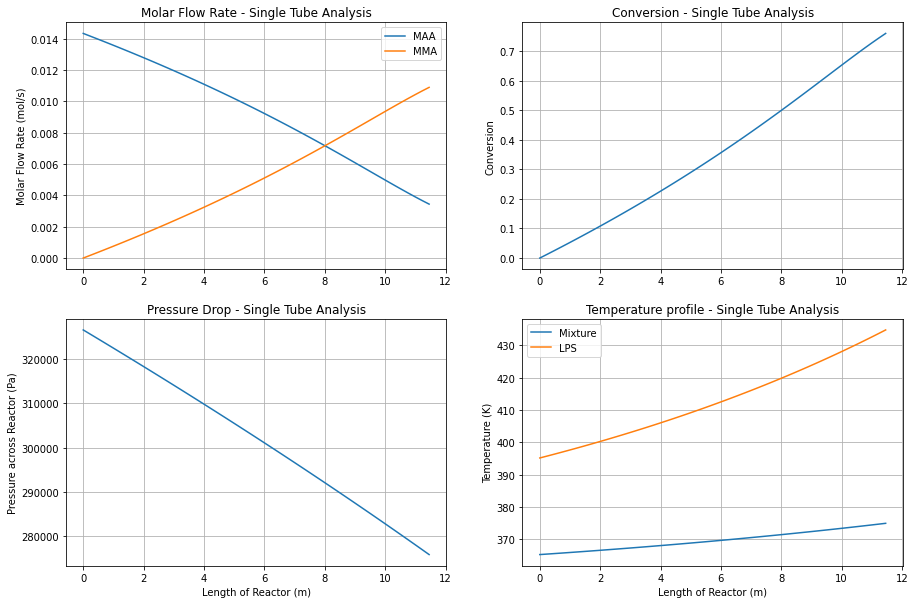

In [56]:
X = sol[:, 0] 
p = sol[:, 1] 
Tm = sol[:, 2] 
Th = sol[:, 3] 

fmaa0 = (inletMFR_MAA*1e3)/3600 #mol/s
fmeoh0 = fmaa0*molarRatio
fmaa0 = fmaa0/numberOfTubes
fmeoh0 = fmeoh0/numberOfTubes

fmaa = [fmaa0*(1-X[i]) for i in range(len(X))]
fmethanol = [fmeoh0-(fmaa0*X[i]) for i in range(len(X))]
fmma = [fmma0+(fmaa0*X[i]) for i in range(len(X))]
#fh2o = [fh2o0+(fmaa0*X[i]) for i in range(len(X))]


fig, axs = plt.subplots(2, 2,figsize=(15,10))

axs[0,0].plot(L,fmaa,label='MAA')
axs[0,0].plot(L,fmma,label='MMA')


axs[0,0].set(ylabel='Molar Flow Rate (mol/s)',title='Molar Flow Rate - Single Tube Analysis')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(L,X)
axs[0,1].set(ylabel='Conversion',title='Conversion - Single Tube Analysis')
axs[0,1].grid()


axs[1,0].plot(L,p)
axs[1,0].set(xlabel='Length of Reactor (m)', ylabel='Pressure across Reactor (Pa)',title='Pressure Drop - Single Tube Analysis')
axs[1,0].grid()

axs[1,1].plot(L,Tm,label='Mixture')
axs[1,1].plot(L,Th,label='LPS')
axs[1,1].legend()
axs[1,1].set(xlabel='Length of Reactor (m)', ylabel='Temperature (K)',title='Temperature profile - Single Tube Analysis')
axs[1,1].grid()

plt.show()


In [57]:
print('Optimized maximum conversion achieved: ', X[-1]*100, '%')

Optimized maximum conversion achieved:  75.98886252330965 %


In [62]:
print('Pressure drop calculated by Ergun: ', (p[0]-p[-1])/100000, 'bar')

Pressure drop calculated by Ergun:  0.5095680369437748 bar
